# MNIST + Convolutional Neural Network
In this notebook we will train a simple convolutional neural networks (CNNs) for classifying hand-written digit images from MNIST data set.  We assume you already know how to access MNIST data set using tensorflow API.

**<font color="red">Warning</font>**
If you already know higher level APIs like [keras](https://keras.io) and [slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) (if you don't, ignore this warning), you see we avoid using them in this notebook purely for educational purpose. You can see the [next tutorial](http://deeplearnphysics.org/Blog/colab-tutorials/2018-03-02-Colab-04-MNIST-Classification-Slim.html) instead.

### Preparation?
You can run this notebook on [google colaboratory](https://colab.research.google.com) with a free K80 GPU. If you are not familiar with MNIST, you can look at [this example](http://deeplearnphysics.org/Blog/colab-tutorials/2018-03-02-Colab-02-MNIST.html). If usefl, also [here](http://deeplearnphysics.org/Blog/colab-tutorials/2018-03-02-Colab-01-TFIntro.html) is tensorflow introduction.

In [1]:
# Import tensorflow
import tensorflow as tf
# Import tensorflow's MNIST data handle
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We use a pedantic way to construct a computational graph in this notebook because it is more educational. Just remember that you can use a higher level APIs (tf.layers, tf.contrib.slim, keras, etc.) to make an equivalent or more complicated computation graph with much less number of steps.

## Define layers: convolution, pooling, and fully-connected 
We will use 3 type of layers (convolution, pooling, and fully-connected layers), and there will be multiple instance of each type. To avoid typing too many texts, it is a common practice to define a function that can create a layer with a few parameters. 

In [2]:
# Import xavier_initializer, a type of initializer we will use for weights
from tensorflow.contrib.layers import xavier_initializer

# Convolution layer
def conv2d(input_tensor, name, num_filter, kernel, stride):
    # From the input tensor, get the number of feature maps
    # The shape of an input tensor is [N,H,W,C] where...
    #    N = number of images in 1 batch
    #    H = height of input tensor
    #    W = width of input tensor
    #    C = channel count of input tensor
    # The number of feture maps = C, so we access the last element
    num_input = input_tensor.get_shape()[-1].value

    # Create graph nodes within this layer's scope
    with tf.variable_scope(name):
        # Create the weights for all neurons (filters)
        weights = tf.get_variable(name='%s_weights' % name,
                                  shape=[kernel[0],kernel[1],num_input,num_filter],
                                  dtype=tf.float32,
                                  initializer=xavier_initializer())
        # Create the biases for all neurons (filters)
        biases  = tf.get_variable(name='%s_biases' % name,
                                  shape=[num_filter],
                                  dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
        # Define convolution operation using weights
        conv = tf.nn.conv2d(input=input_tensor,
                            filter=weights,
                            strides=(1, stride[0], stride[1], 1),
                            padding='SAME')
        
        # Define activation operation with an argument = neuron sum
        activation = tf.nn.relu(tf.nn.bias_add(conv, biases))

        # Register variables to be monitored in tensorboard
        tf.summary.histogram('%s_weights' % name, weights)
        tf.summary.histogram('%s_biases' % name, biases)
        tf.summary.histogram('%s_activation' % name, activation)

    return activation
    
# Pooling layer
def max_pool(input_tensor,name,kernel,stride):
    # Create graph nodes within this layer's scope
    with tf.variable_scope(name):

        pool = tf.nn.max_pool(value=input_tensor,
                              ksize=[1, kernel[0], kernel[1], 1],
                              strides=[1, stride[0], stride[1], 1],
                              padding='SAME')
    return pool

# Fully connected layer
def fully_connected(input_tensor, name, num_output, activation=None):
    # Flatten the input tensor to 1D array 
    shape=input_tensor.get_shape()
    flat_size = 1
    for index in range(len(shape)-1):
        flat_size *= shape[1-len(shape)+index].value
    input_tensor = tf.reshape(input_tensor, [-1,flat_size])

    # Create graph nodes within this layer's scope
    with tf.variable_scope(name):
        # Weights for neurons
        weights = tf.get_variable(name='%s_weights' % name,
                                  shape=[input_tensor.get_shape()[-1].value, num_output],
                                  dtype=tf.float32,
                                  initializer=xavier_initializer())
        # Biases for neurons
        biases  = tf.get_variable(name='%s_biases' % name,
                                  shape=[num_output],
                                  dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
        
        # Compute neuron sums
        result = tf.matmul(input_tensor,weights) + biases
        
        # Activation
        if activation:
            result = activation(result)
        
        # Register variables to be monitored in tensorboard
        tf.summary.histogram('%s_weights' % name, weights)
        tf.summary.histogram('%s_biases' % name, biases)

    return result

## Design the network
By having those functions defining the details, now we can have a simple description of the overall network design. Let's first define our input place holders. They serve to feed input data image, correct prediction labels, and also a dropout fraction for a fully connected layer.

In [3]:
# Network inputs
with tf.variable_scope('input'):
    images    = tf.placeholder(tf.float32, shape=[None, 784])
    labels    = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    image2d   = tf.reshape(images, [-1, 28, 28, 1])
    # Record a random 10 samples of images in monitoring
    tf.summary.image('images',image2d,10)

Here's the full design of the network. It is important to try keeping this trivial so that your friends can have an abstract understanding quickly.

In [4]:
# Design a network
def build(input_tensor, debug=False):
    # Design a network
    
    # Convolution 1
    conv1 = conv2d   (input_tensor, 'conv1', 32, [5,5], [1,1])
    # Pooling 1
    pool1 = max_pool (conv1,        'pool1',     [2,2], [2,2])
    # Convolution 2
    conv2 = conv2d   (pool1,        'conv2', 64, [5,5], [1,1])
    # Pooling 2
    pool2 = max_pool (conv2,        'pool2',     [2,2], [2,2])

    # FC1
    fc1 = fully_connected(pool2, 'fc1', 1024, tf.nn.relu)
    with tf.variable_scope('drop_out'):
        drop = tf.nn.dropout(fc1, keep_prob)
    # FC2
    fc2 = fully_connected(drop, 'fc2', 10)
    
    # Dimension check if debug is True
    if debug:
        print('Input shape:', input_tensor.shape )
        print('After conv1:', conv1.shape        )
        print('After pool1:', pool1.shape        )
        print('After conv2:', conv2.shape        )
        print('After pool2:', pool2.shape        )
        print('After fc1  :', fc1.shape          )
        print('After fc2  :', fc2.shape          )
        
    return fc2    

Let's now build it! We enable the debug flag to print out the dimensionality here.

In [5]:
net = build(image2d, debug=True)

('Input shape:', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]))
('After conv1:', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(32)]))
('After pool1:', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(32)]))
('After conv2:', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(64)]))
('After pool2:', TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(64)]))
('After fc1  :', TensorShape([Dimension(None), Dimension(1024)]))
('After fc2  :', TensorShape([Dimension(None), Dimension(10)]))


## Define loss and optimizer
The final step before training... is to define a train step operation! Below we define our loss using softmax (multinominal logistic regression) and we use AdamOptimizer. There is no special reason for this choice. Feel free to try out different optimizers!


In [6]:
# Train operations
with tf.variable_scope("train"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=net))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Monitor these loss and accuracy during training
    tf.summary.scalar('loss',loss)
    tf.summary.scalar('accuracy',accuracy)

## Create a session and tensorboard log
Finally, we are almost ready for the training. Let's create a session + log writer that can record everything we added to tf.summary into the training log. We will visualize it later using tensorboard.

In [7]:
# Define a session
sess = tf.InteractiveSession()

# Create log monitor
import os
if not os.path.isdir('tb_log'): os.makedirs('tb_log')
log_writer = tf.summary.FileWriter('tb_log')
log_writer.add_graph(sess.graph)
summary_op = tf.summary.merge_all()

## Train
Ready? Here's the training loop!

In [8]:
# Let's time this
import time
start = time.time()

# Ready! initialize and train for 5000 steps
sess.run(tf.global_variables_initializer())
for i in range(2000):

    # Fetch data of 50 images
    batch = mnist.train.next_batch(50)

    # Every 100 steps, compute & print the accuracy of the network's prediction
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    
    # Every 20 steps, compute & record tensorboard log
    if i % 20 == 0:
        s = sess.run(summary_op, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0})
        log_writer.add_summary(s,i)

    # Every step run training!
    sess.run(train_step, feed_dict={images: batch[0], labels: batch[1], keep_prob: 0.5})

# Compute & print out the final accuracy
batch = mnist.test.next_batch(200)
print('test accuracy %g' % sess.run(accuracy, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0}))
print(time.time() - start)

step 0, training accuracy 0
step 100, training accuracy 0.72
step 200, training accuracy 0.9
step 300, training accuracy 0.88
step 400, training accuracy 0.98
step 500, training accuracy 0.98
step 600, training accuracy 0.96
step 700, training accuracy 0.94
step 800, training accuracy 0.94
step 900, training accuracy 0.88
step 1000, training accuracy 0.98
step 1100, training accuracy 0.96
step 1200, training accuracy 1
step 1300, training accuracy 0.92
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 0.98
step 1700, training accuracy 0.96
step 1800, training accuracy 1
step 1900, training accuracy 1
test accuracy 0.9791
23.5245790482


So it took 23 seconds and the accuracy is just below 100%. Not too bad :)

## Analysis
The results look pretty good: the accuracy is almost 100% correct most of times. But it's _really_ important for you to double-check this by visually checking the results. I cannot stress this point! So let's do analysis. We will dump some MNIST images, correct labels, and prediction by the network.

Prediction 7 with softmax prob 0.999986 


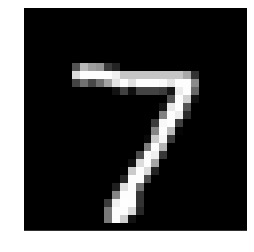

Prediction 2 with softmax prob 0.999862 


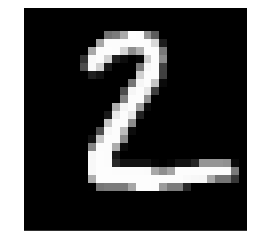

Prediction 1 with softmax prob 0.993158 


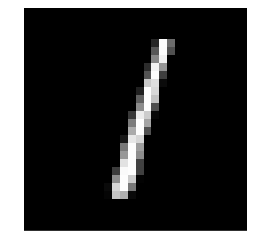

Prediction 0 with softmax prob 0.999947 


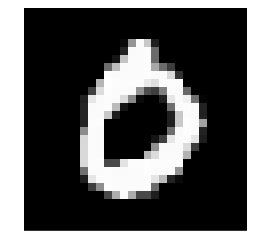

Prediction 4 with softmax prob 0.999807 


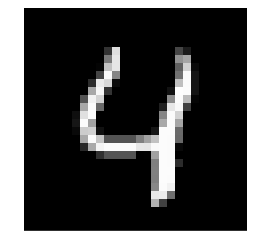

Prediction 1 with softmax prob 0.996322 


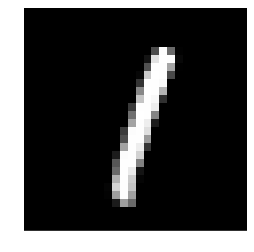

Prediction 4 with softmax prob 0.996765 


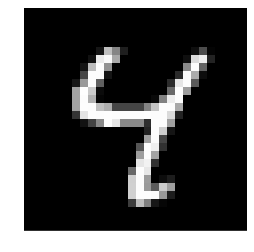

Prediction 9 with softmax prob 0.973803 


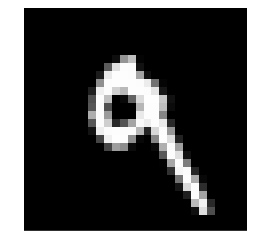

Prediction 5 with softmax prob 0.992624 


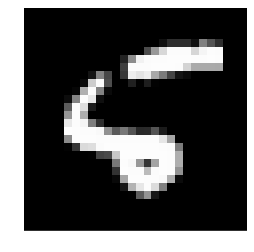

Prediction 9 with softmax prob 0.995477 


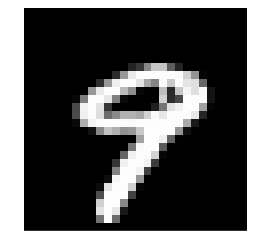

In [9]:
# Define operations: a softmax probability, and the prediction by the network
with tf.variable_scope('analysis'):
    softmax = tf.nn.softmax(logits=net)
    prediction_label = tf.argmax(net,1)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Dump some output images
prob_array, pred_label, = sess.run([softmax,prediction_label],feed_dict={images: mnist.test.images,keep_prob:1.0})
for index in range(10):
    print 'Prediction\033[91m',pred_label[index],'\033[00mwith softmax prob\033[94m',prob_array[index][pred_label[index]],'\033[00m'
    plt.imshow(mnist.test.images[index].reshape([28,28]).astype(np.float32),cmap='gray',interpolation='none')
    plt.axis('off')
    plt.show()


## Training speed 
The last training loop took about 23 seconds, which was not very fast (though that's relative). In fact, the most of time consumed was due to creating tensorboard log recorded every 20 steps. For the last exercise in this notebook, let's take out log creation and compare the speed.

In [10]:
# Let's time this
import time
start = time.time()

# Ready! initialize and train for 5000 steps
sess.run(tf.global_variables_initializer())
for i in range(2000):

    # Fetch data of 50 images
    batch = mnist.train.next_batch(50)

    # Every 100 steps, compute & print the accuracy of the network's prediction
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    
    # Every step run training!
    sess.run(train_step, feed_dict={images: batch[0], labels: batch[1], keep_prob: 0.5})

# Compute & print out the final accuracy
batch = mnist.test.next_batch(200)
print('test accuracy %g' % sess.run(accuracy, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0}))
print(time.time() - start)

step 0, training accuracy 0.12
step 100, training accuracy 0.94
step 200, training accuracy 0.94
step 300, training accuracy 0.92
step 400, training accuracy 0.98
step 500, training accuracy 0.96
step 600, training accuracy 0.96
step 700, training accuracy 0.92
step 800, training accuracy 0.96
step 900, training accuracy 0.9
step 1000, training accuracy 1
step 1100, training accuracy 0.96
step 1200, training accuracy 0.98
step 1300, training accuracy 0.98
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.96
step 1700, training accuracy 0.94
step 1800, training accuracy 1
step 1900, training accuracy 1
test accuracy 0.9801
7.02695202827


7 seconds ... which is more than factor of 3 faster than the last training loop! So, as said, most time was spent writing a training log during the last attempt.

## Closing remark
In this notebook we trained a very simple, 2 layers convolutional neural networks followed by 2 fully connected layers. This worked fairly well for MNIST digit classification. As a homework assignment, you might want to try:

* Make a simple neural network (NN) with 2 fully connected layers. Train and see how well it works.
* Get a digit image of 1, and use numpy operations to "shift" the location of digit to left or right. Compare how well CNNs vs. NN can handle the translation!